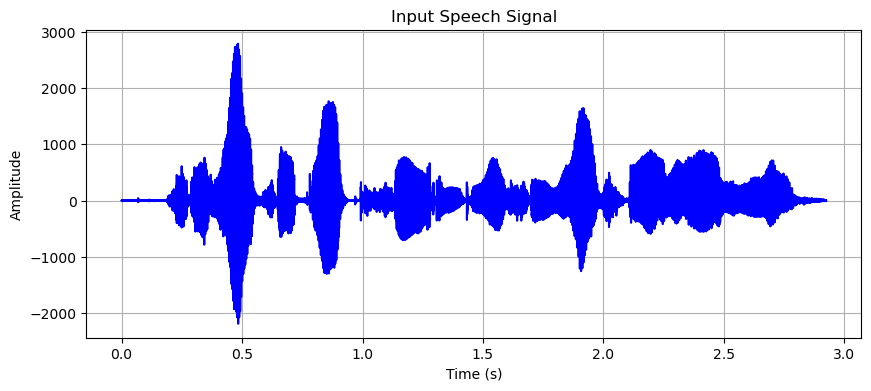

46797

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Load the file 
file_path = "C:\\Users\ssshr\\Downloads\\LDC93S1 (1).wav" 
sample_rate, data = wavfile.read(file_path)
time = np.arange(0, len(data)) / sample_rate

# normalize
normalized_data = data / np.max(np.abs(data))

# Plot 
plt.figure(figsize=(10, 4))
plt.plot(time, data, color='b')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input Speech Signal')
plt.grid(True)
plt.show()
len(data)

2: Segment signal into windows

In [2]:
def segment_signal(signal, window_size_ms, sampling_rate, overlap_ms):
    # Convert window size from milliseconds to samples
    window_size_samples = int(window_size_ms * sampling_rate / 1000)
    overlap_samples = int(overlap_ms * sampling_rate / 1000)

    # Calculate the step size for windowing
    step_size = window_size_samples - overlap_samples
    
    # Initialize empty list to store segments
    segmented_signal = []
    
    # Iterate over the signal, segmenting it into windows with overlap
    start_idx = 0

    while start_idx + window_size_samples <= len(signal):
        end_idx = start_idx + window_size_samples
        segmented_signal.append(signal[start_idx:end_idx])
        start_idx += step_size
    
    return np.array(segmented_signal)

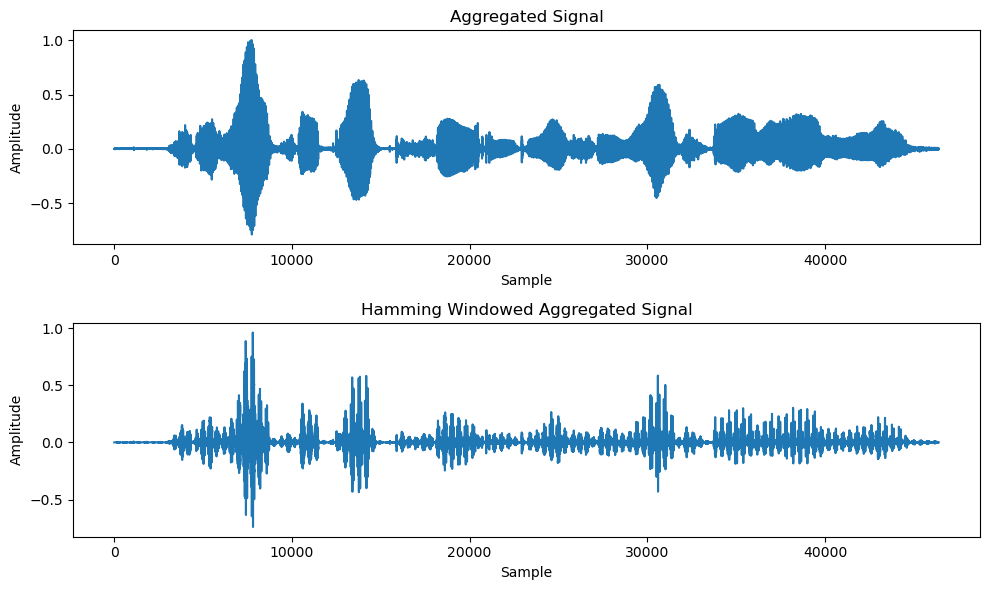

In [3]:
# segment signal into frames, and apply Hamming window 
segments = segment_signal(normalized_data, 25, sample_rate, 0)
segmented_signal = np.concatenate(segments)
window = np.hamming(len(segments[0]))
hamming_windowed_segments = [segment * window for segment in segments]
windowed_signal = np.concatenate(hamming_windowed_segments)

# Plot original aggregated signal and Hamming windowed version
plt.figure(figsize=(10, 6))

# Original aggregated signal
plt.subplot(2, 1, 1)
plt.plot(segmented_signal)
plt.title('Aggregated Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')


# Hamming windowed version
plt.subplot(2, 1, 2)
plt.plot(windowed_signal)

# # Plot vertical lines at the values in the data list
# for start, end in data:
#     plt.axvline(x=start, color='r', linestyle='--')
#     plt.axvline(x=end, color='r', linestyle='--')


plt.title('Hamming Windowed Aggregated Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

RMS peak heights: [0.00010077939301116909, 6.828670733283152e-05, 0.000146418251428281, 0.00010219255118276081, 7.478253023288461e-05, 0.00016120601103006795, 0.0001310051622477013, 0.00037593268742950475, 0.019470975552085112, 0.07414696214218451, 0.06850825619196564, 0.02641877970078358, 0.36486922397433136, 0.7287808984742593, 0.14738363650256814, 0.1496828396787617, 0.34963746285272357, 1.622437973629879, 6.990137586346996, 9.832139242967854, 2.233905596402816, 1.4954567017609242, 0.01841420457390036, 0.004136082009040821, 0.024926747348097338, 0.0069472800331584535, 1.4931870702756331, 0.9750981624701213, 0.44372069289747296, 0.0050347791338546145, 0.004989672517694756, 0.035228656976975435, 0.7887764551887381, 3.272331453531697, 3.0037419870491413, 2.650911891250736, 0.11522134541192039, 0.0005122843158890936, 0.00011146400564957428, 0.002569564520073987, 0.017216806955910956, 0.0033141373168710923, 0.006794240017594703, 0.011526104089091183, 0.00746038142975869, 0.12286767919657

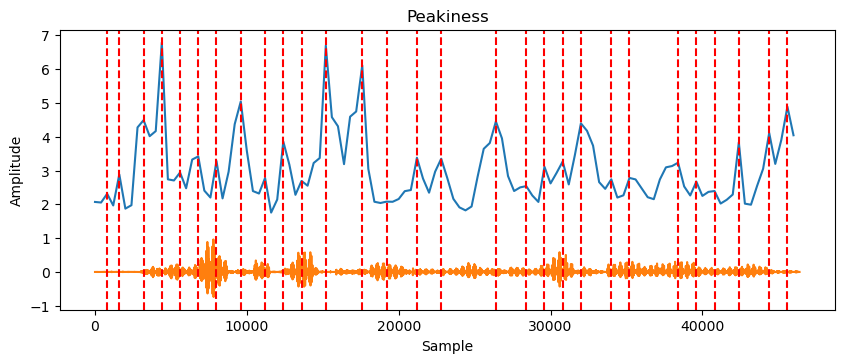

In [4]:
# for every window, report key metrics

# 1. peakiness 
from scipy.signal import find_peaks
def autocorr_peak_heights(windowed_signal):
    rms_peak_heights = []
    max_peak_heights = []

    for window in windowed_signal:
        autocorr = np.correlate(window, window, mode='full')
        autocorr = autocorr[len(autocorr)//2:]

        # Find peaks in autocorrelation
        peaks, _ = find_peaks(autocorr)

        if len(peaks) > 0:
            # Calculate peak heights
            peak_heights = autocorr[peaks]
            rms_peak_height = np.sqrt(np.mean(np.square(peak_heights)))
            max_peak_height = np.max(peak_heights)

            rms_peak_heights.append(rms_peak_height)
            max_peak_heights.append(max_peak_height)
        else:
            # If no peaks found, append NaN
            rms_peak_heights.append(np.nan)
            max_peak_heights.append(np.nan)

    return rms_peak_heights, max_peak_heights

# Calculate peak heights
rms_peak_heights, max_peak_heights = autocorr_peak_heights(hamming_windowed_segments)

print("RMS peak heights:", rms_peak_heights)
print("Highest peak heights:", max_peak_heights)

peakiness = [max_peak / rms_peak for max_peak, rms_peak in zip(max_peak_heights, rms_peak_heights)]

plt.figure(figsize=(10, 8))

x = [i * 400 for i in range(116)]
plt.subplot(2, 1, 1)
plt.plot(x, peakiness)
plt.title('Peakiness')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.plot(windowed_signal)


peakiness_indices, _ = find_peaks(peakiness)
print(peakiness_indices) 

for drop in (peakiness_indices * 400):
    plt.axvline(x=drop, color='r', linestyle='--') 

# plt.subplot(2, 1, 2)
# plt.scatter(x, peakiness)
# plt.title('Peakiness')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')

# plt.tight_layout()
# plt.show()




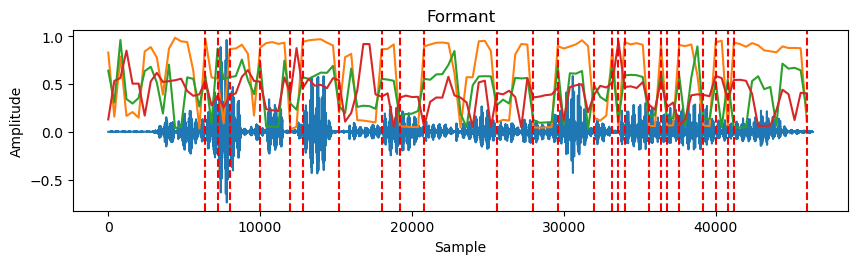

In [24]:
import librosa
from scipy.signal import lfilter 
# # LPC analysis
order = 12  # LPC order (number of coefficients)

first_formants = [] 
second_formants = [] 
third_formants = [] 

for window in hamming_windowed_segments:
    lpc_coefficients = librosa.lpc(window, order=order)
    lpc_roots = np.roots(lpc_coefficients)
    positive_imag_roots = lpc_roots[lpc_roots.imag > 0]
    positive_imag_roots = positive_imag_roots[:4]
    # threshold against some magnitue 
    first_formants.append((np.angle(positive_imag_roots) * sample_rate / (2 * np.pi)).tolist()[0])
    second_formants.append((np.angle(positive_imag_roots) * sample_rate / (2 * np.pi)).tolist()[1])
    third_formants.append((np.angle(positive_imag_roots) * sample_rate / (2 * np.pi)).tolist()[2])
    
plt.figure(figsize=(10, 8))

x = [i * len(hamming_windowed_segments[0]) for i in range(len(hamming_windowed_segments))]
plt.subplot(3, 1, 1)
plt.title('Formant')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.plot(windowed_signal)
plt.plot(x, [ i / 8000 for i in first_formants])
plt.plot(x, [ i / 8000 for i in second_formants])
plt.plot(x, [ i / 8000 for i in third_formants])

threshold = 0.7
for i in range(1, len(first_formants)):
    diff_1 = abs(first_formants[i] - first_formants[i-1]) / 8000
    diff_2 = abs(second_formants[i] - second_formants[i-1]) / 8000
    diff_3 = abs(third_formants[i] - third_formants[i-1]) / 8000
    if diff_1 > threshold or diff_2 > threshold or diff_3 > threshold:
        plt.axvline(x=i * len(hamming_windowed_segments[0]), color='r', linestyle='--')
 
# time_axis = np.arange(0, len(windowed_signal) / sample_rate, 400 / sample_rate).tolist()
# plt.figure(figsize=(10, 6))  # Adjust figure size as needed
# for i in range(len(hamming_windowed_segments)):
#     plt.plot([time_axis[i]] * 4, formants[i], 'bo')  # Plot each angle with corresponding window index
#     plt.axvline(x=i, color='r', linestyle='--')
# plt.xlabel('Window Index')
# plt.ylabel('Angles')
# plt.title('Angles vs Window Index')
# plt.grid(True)
# plt.show()
# print(formants)

# # Compute the narrowband spectrogram
# narrowband_spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(windowed_signal, hop_length=128)), ref=np.max)

# # Plot the narrowband spectrogram
# plt.figure(figsize=(10, 6))
# librosa.display.specshow(narrowband_spectrogram, sr=sample_rate, hop_length=128, x_axis='time', y_axis='log')

# # Calculate the time points for the vertical lines
# time_points = np.arange(0, len(windowed_signal) / sample_rate, 0.0025)

# # Draw vertical lines at each time point
# for time_point in time_points[:10]:
#     plt.axvline(x=time_point, color='r', linestyle='--')

# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.title('Narrowband Spectrogram with Vertical Lines')
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()
# plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


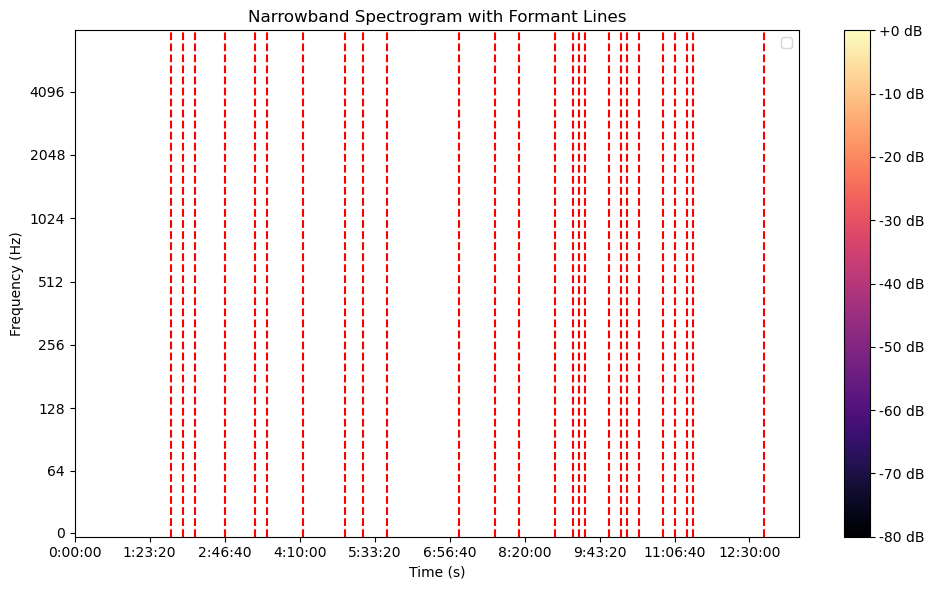

In [27]:

# Compute the narrowband spectrogram
narrowband_spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(windowed_signal, hop_length=128)), ref=np.max)

# Plot the narrowband spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(narrowband_spectrogram, sr=sample_rate, hop_length=128, x_axis='time', y_axis='log')

for i in range(1, len(first_formants)):
    diff_1 = abs(first_formants[i] - first_formants[i-1]) / 8000
    diff_2 = abs(second_formants[i] - second_formants[i-1]) / 8000
    diff_3 = abs(third_formants[i] - third_formants[i-1]) / 8000
    if diff_1 > threshold or diff_2 > threshold or diff_3 > threshold:
        plt.axvline(x=i * len(hamming_windowed_segments[0] * 128 / sample_rate), color='r', linestyle='--')

# Customize the plot
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Narrowband Spectrogram with Formant Lines')
plt.colorbar(format='%+2.0f dB')
plt.legend()
plt.tight_layout()
plt.show()


## Fuzzy Smooth Energy Contour

In [29]:
# root cepstrum truncation to smooth group delay function has the issue of the length of window affecting the number of detected syllables 

# Novel method: computing short term energy, fuzzy based smoothing, boundary detection 
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6168554&tag=1 

teager_energy = []

# compute Teager energy 
for window in hamming_windowed_segments:
    energy = 0
    for i in range(0, len(window)):
        if (i == 0):
            energy += window[i] ** 2 - window[i + 1]
        elif (i == len(window) - 1):
            energy += window[i] **  2 - window[i - 1]
        else: 
            energy += window[i]**2 - (window[i + 1] * window[i - 1])
    teager_energy.append(energy)


# fuzzy based smoothing 


### Using RMS and Zero Crossings

In [33]:
from scipy.stats import chi2

p_values = [] 
for window in hamming_windowed_segments:
    # Fit a chi-squared distribution to the window of samples
    df, loc, scale = chi2.fit(window)

    # Evaluate the PDF of the fitted chi-squared distribution
    x = np.linspace(chi2.ppf(0.001, df), chi2.ppf(0.999, df), 1000)

    pdf_estimate = chi2.pdf(x, df, loc, scale)

    p_values.append(pdf_estimate)

print(p_values[0])

    
# plt.figure(figsize=(8, 6))
# plt.plot(x, pdf_estimate, label='PDF Estimate')
# plt.xlabel('Sample Value')
# plt.ylabel('Probability Density')
# plt.title('Estimated PDF of Window of Samples (Chi-squared distribution)')
# plt.legend()
# plt.grid(True)
# plt.show()

[5.33837069e+01 8.52372625e+00 4.95812708e+00 3.56133558e+00
 2.80238431e+00 2.32100800e+00 1.98647443e+00 1.73946841e+00
 1.54903858e+00 1.39739449e+00 1.27355617e+00 1.17036584e+00
 1.08295034e+00 1.00787250e+00 9.42635854e-01 8.85381671e-01
 8.34696450e-01 7.89485376e-01 7.48886773e-01 7.12212815e-01
 6.78907514e-01 6.48516384e-01 6.20664139e-01 5.95038050e-01
 5.71375346e-01 5.49453554e-01 5.29083007e-01 5.10100973e-01
 4.92367000e-01 4.75759204e-01 4.60171279e-01 4.45510064e-01
 4.31693560e-01 4.18649293e-01 4.06312961e-01 3.94627303e-01
 3.83541157e-01 3.73008660e-01 3.62988574e-01 3.53443716e-01
 3.44340464e-01 3.35648339e-01 3.27339642e-01 3.19389146e-01
 3.11773816e-01 3.04472581e-01 2.97466126e-01 2.90736708e-01
 2.84268002e-01 2.78044959e-01 2.72053681e-01 2.66281317e-01
 2.60715960e-01 2.55346564e-01 2.50162868e-01 2.45155323e-01
 2.40315034e-01 2.35633704e-01 2.31103583e-01 2.26717425e-01
 2.22468445e-01 2.18350284e-01 2.14356976e-01 2.10482918e-01
 2.06722841e-01 2.030717

C:\Users\ssshr\AppData\Local\Temp\ipykernel_49412\1025676333.py:5: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(np.sqrt(pdf1 * pdf2), x)


[0.0, 0.4906516243821291, 0.09779738354861701, 0.34601627223014875, 0.09779738354861701, 1.0, 0.9055189856349675, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.34531830028887434, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.6437186539294312, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.70701106868696, 0.09779738354861701, 0.3080606156611904, 0.2357749115798465, 0.3667967550944311, 0.4229572673783836, 0.8359227493054567, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.09779738354861701, 0.6387090114968078, 0.626796348580836, 0.6212127995126729, 0.28466378016917154, 0.653609121383489

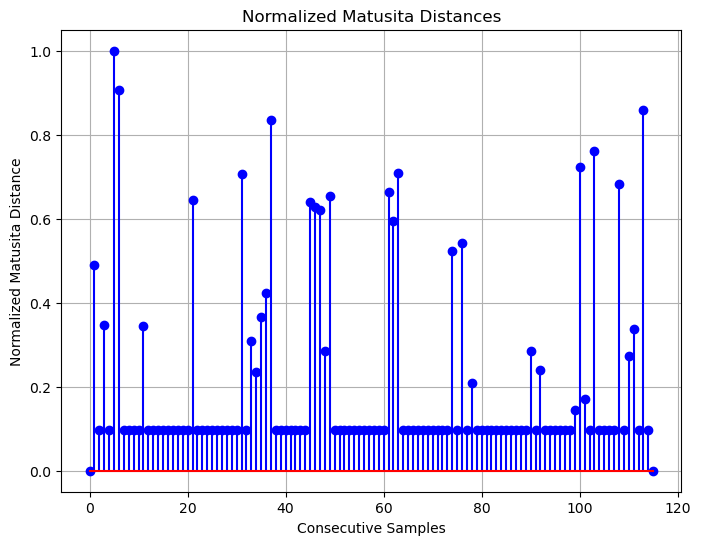

In [48]:
from scipy.integrate import simps 

# https://www.csd.uoc.gr/~tziritas/papers/SpeechMusicEusipco.pdf
datavalues = np.linspace(chi2.ppf(0.001, df), chi2.ppf(0.999, df), 1000)
def matusita_distance(pdf1, pdf2, x):
    integral = simps(np.sqrt(pdf1 * pdf2), x)

    return 1 - integral 

matusita_distances = []
for i in range(1, len(hamming_windowed_segments) - 1):
    matusita_distances.append(matusita_distance(p_values[i - 1], p_values[i + 1], datavalues))

matusita_distances.insert(0, 0)
matusita_distances.append(0)
# print(matusita_distances)
# print(abs(max(matusita_distances, key=abs)))
norm_matusita_distances = [abs(i / abs(max(matusita_distances, key=abs))) for i in matusita_distances]
print(norm_matusita_distances)

plt.figure(figsize=(8, 6))
plt.stem(norm_matusita_distances, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel('Consecutive Samples')
plt.ylabel('Normalized Matusita Distance')
plt.title('Normalized Matusita Distances')
plt.grid(True)
plt.show()

[5, 6, 21, 31, 37, 45, 46, 47, 49, 61, 63, 100, 103, 108, 113]


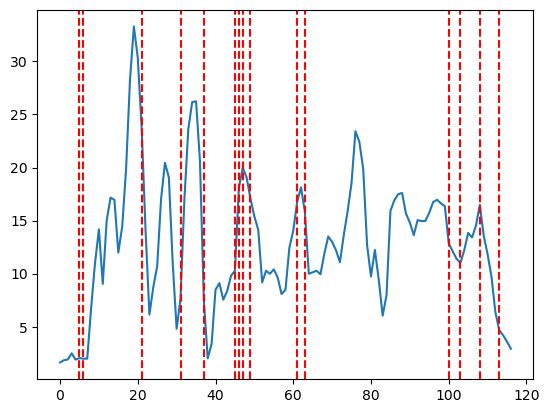

In [58]:
# threshold at 0.75 
window_size = 400
rms_values = np.sqrt(librosa.feature.rms(y=data, frame_length=window_size, hop_length=window_size)[0])

indices_above_075 = [i for i, value in enumerate(norm_matusita_distances) if value > 0.6]
print(indices_above_075)

plt.plot(rms_values)

# find the time instant where two successive frames are located before and after this instant have the maximum distance 
for i in indices_above_075:
    plt.axvline(x=i , color='r', linestyle='--')

## DWT
https://www.inf.u-szeged.hu/~ggabor/publlist/2008-icaisc.pdf 

C:\Users\ssshr\AppData\Local\Temp\ipykernel_49412\2615883257.py:29: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  smoothed_signal = tukey(785, 0.5)


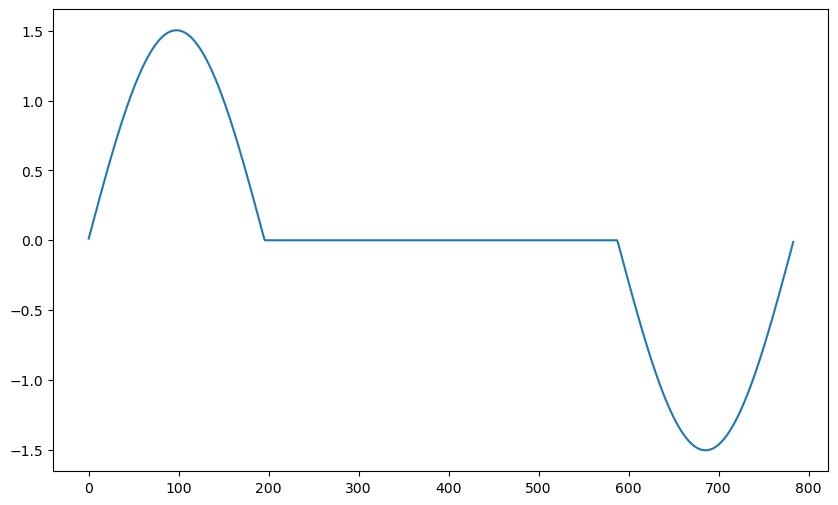

In [97]:
import pywt 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import tukey

# Example wavelet and level of decomposition
wavelet = 'dmey'  
level = 6

# Perform the Discrete Wavelet Transform (DWT)
coefficients = pywt.wavedec(windowed_signal, wavelet, level=level)

sum_pairs = [coefficients[2][i] + coefficients[2][i + 1] for i in range(0, len(coefficients[2]) - 1, 2)]
#print(len(sum_pairs))
power = [] 
for i in coefficients: 
    #print(len(i))
    power_spectrum = 0 
    for coef in i:
        power_spectrum += np.abs(coef) ** 2
    power.append(power_spectrum)

# band reduction 


smoothed_power_spectrum = [] 
for i in power: 
    # Apply Tukey smoothing
    smoothed_signal = tukey(785, 0.5)
    smoothed_power_spectrum.append(i * smoothed_signal)   
#print(smoothed_power_spectrum)

derivatives = [] 
for i in smoothed_power_spectrum:
    derivatives.append(np.diff(i))


new_list = [] 
for i in derivatives:
    new_list.append(i[:786])


difference = [sum(column) for column in zip(*new_list)]

#print(difference)
plt.figure(figsize=(10, 6))
plt.plot(difference)

# # Compute the power spectrum of the DWT coefficients
# power_spectrum = np.zeros_like(windowed_signal)
# for coef in coefficients:
#     power_spectrum += np.abs(coef) ** 2

# # Normalize the power spectrum (optional)
# power_spectrum /= np.max(power_spectrum)

# # Plot the power spectrum
# plt.figure(figsize=(10, 6))
# plt.plot(power_spectrum)
# plt.xlabel('Frequency')
# plt.ylabel('Power Spectrum')
# plt.title('Power Spectrum of Discrete Wavelet Transform')
# plt.grid(True)
# plt.show()


In [74]:
data = [
    #(0, 7470),
    (7470, 9840),
    (9840, 11362),
    (11362, 12908),
    (12908, 14760),
    (14760, 15420),
    (15420, 16000),
    (16000, 17503),
    (17503, 18540),
    (18540, 18950),
    (18950, 21053),
    (21053, 22200),
    (22200, 22740),
    (22740, 23360),
    (23360, 25315),
    (25315, 27643),
    (27643, 28360),
    (28360, 29272),
    (29272, 29932),
    (29932, 30960),
    (30960, 31870),
    (31870, 32550),
    (32550, 33253),
    (33253, 34660),
    (34660, 35890),
    (35890, 36971),
    (36971, 38391),
    (38391, 40690),
    (40690, 42290),
    (42290, 43120),
    (43120, 43906),
    (43906, 45480),
    (45480, 46040),
    (46040, 47480),
    (47480, 49021),
    (49021, 51348),
    (51348, 52184),
    (52184, 54147),
    (54147, 56654),
    (56654, 58840),
    #(58840, 61680)
]


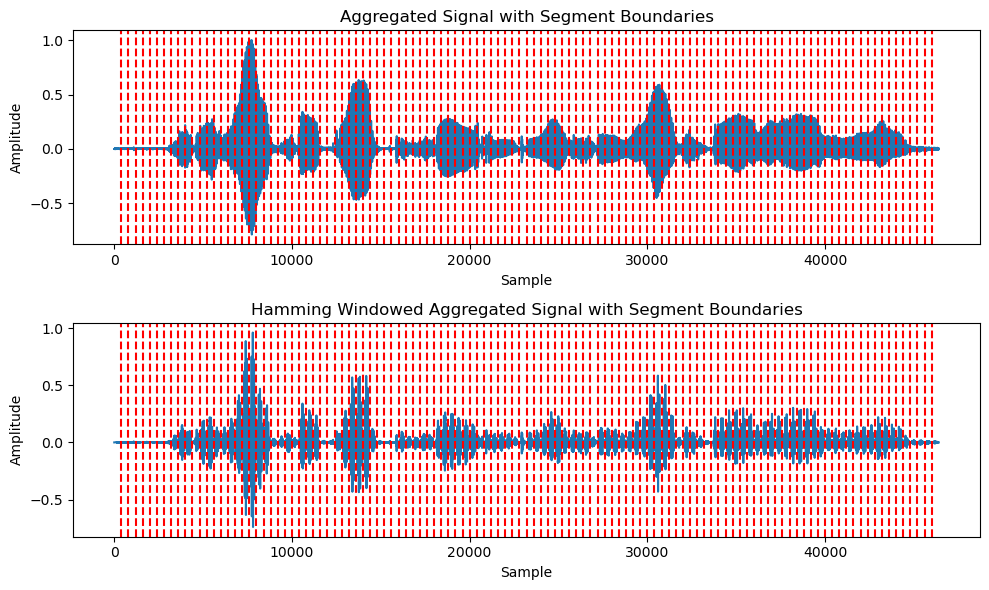

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Compute segment lengths
segment_lengths = [len(segment) for segment in segments]

# Compute accumulated segment lengths
accumulated_lengths = np.cumsum(segment_lengths)

# Plot original aggregated signal and Hamming windowed version
plt.figure(figsize=(10, 6))

# Original aggregated signal
plt.subplot(2, 1, 1)
plt.plot(segmented_signal)

# Plot vertical lines at segment boundaries
for length in accumulated_lengths[:-1]:
    plt.axvline(x=length, color='r', linestyle='--')

plt.title('Aggregated Signal with Segment Boundaries')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Hamming windowed version
plt.subplot(2, 1, 2)
plt.plot(windowed_signal)

# Plot vertical lines at segment boundaries
for length in accumulated_lengths[:-1]:
    plt.axvline(x=length, color='r', linestyle='--')

plt.title('Hamming Windowed Aggregated Signal with Segment Boundaries')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


## Novel algorithm

In [63]:
a = 2
b = 0
c = 3
j_vals = []
for seg in range(len(segments)):
    # compute  J function 
    j = 0
    for count in range(seg - a, seg):
        j += segments[seg][count]
    for count in range(seg + 1, seg + a + 1):
        j -= segments[seg][count]
    j_vals.append(j / a)

# detect peaks in J according to threshold b 
s = []
for j in j_vals:
    if j >= b:
        s.append(1)
    else:
        s.append(0)




In [64]:
# fitting procedure
p = 0
q = 3
acc = [0] * len(s) 
for n in range(a, len(segments) - a - c):
    # compute f[n] for each n in the range (p, q)
    f_min = np.Inf
    min_index = 0  
   
    for v in range(n, n + c + 1):
        f = 0 
        for m in range(n, n + c + 1):
            for i in range(1, 2):
                f += s[m * i] * np.abs(v - m)
        if (f < f_min):
            f_min = f 
            min_index = v
    nwin = min_index 
   
    acc[nwin] += 1 
    
new_acc = [1 if i > 2 else 0 for i in acc]
np.count_nonzero(new_acc)



# for n in range(0, len(f_vals)):
#     f_min = f_vals[n]
#     f_min_index = 0 
#     for i in range(n, n + c):
#         if (f_vals[i] < f_min):
#             f_min = f_vals[i]
#             f_min_index = i 
#         print(f_min_index)
#     nwin = f_min_index 
#     acc[nwin] = acc[nwin] + 1






10

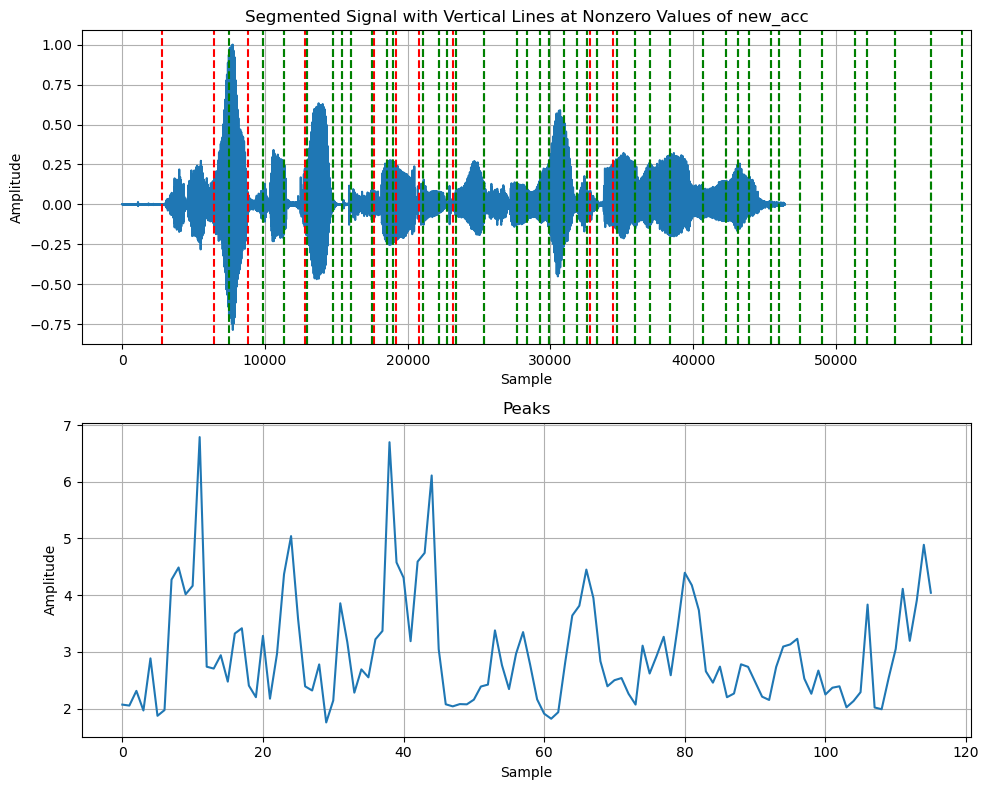

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming segmented_signal, new_acc, and peaks are already computed
# segmented_signal = ...
# new_acc = ...
# peaks = ...

# Create figure and subplots
plt.figure(figsize=(10, 8))

# Plot segmented_signal
plt.subplot(2, 1, 1)
plt.plot(segmented_signal)

# Find indices of nonzero values in new_acc and multiply by 220
indices = np.nonzero(new_acc)[0] * len(segments[0])

# Plot vertical lines at the calculated indices
for index in indices:
    plt.axvline(x=index, color='r', linestyle='--')

for (x, y) in data:
    plt.axvline(x=x, color='g', linestyle='--')
    plt.axvline(x=y, color='g', linestyle='--')

plt.title('Segmented Signal with Vertical Lines at Nonzero Values of new_acc')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

# Plot peaks
plt.subplot(2, 1, 2)
plt.plot(peakiness)

plt.title('Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()


2800
6400
8800
12800
17600
19200
20800
23200
32800
34400


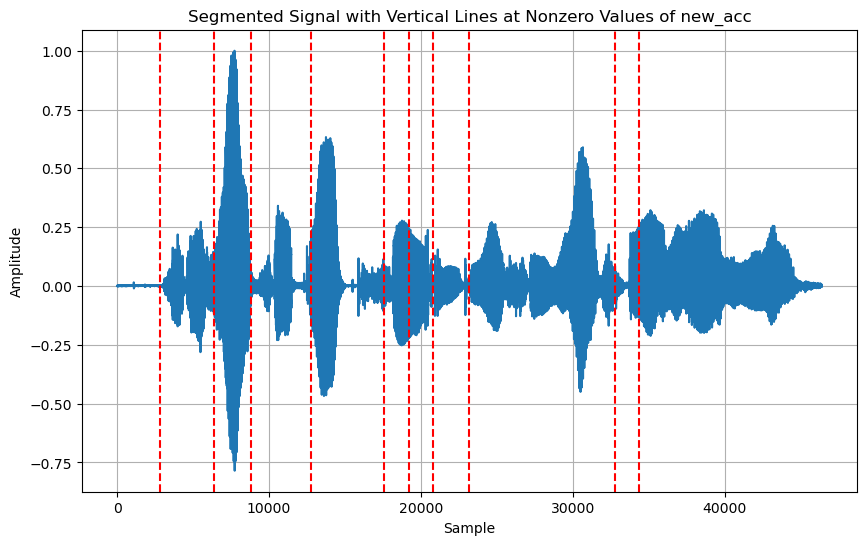

In [71]:
# Plot segmented_signal
plt.figure(figsize=(10, 6))
plt.plot(segmented_signal)

# Find indices of nonzero values in new_acc and multiply by 220
indices = np.nonzero(new_acc)[0] * 400

# Plot vertical lines at the calculated indices
for index in indices:
    print(index)
    plt.axvline(x=index, color='r', linestyle='--')


plt.title('Segmented Signal with Vertical Lines at Nonzero Values of new_acc')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Amplitude')

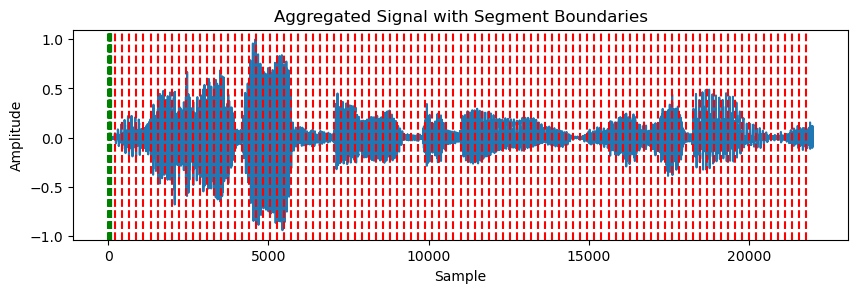

In [105]:
# plt.title('Acc')
# plt.subplot(3, 1, 1)
# plt.plot(acc)
# plt.title('Acc')
# plt.xlabel('Sample')
# plt.ylabel('Acc')
# plt.subplot(3, 1, 2)
# plt.plot(segments[0])
# plt.title('Segments[0]')
# plt.xlabel('Sample')
# plt.ylabel('Acc')
# plt.subplot(3, 1, 3)
# plt.plot(segmented_signal[:500])
# plt.title('Segments[0]')
# plt.xlabel('Sample')
# plt.ylabel('Acc')
# plt.tight_layout()
# plt.tight_layout()

import numpy as np
import matplotlib.pyplot as plt

# Assuming segmented_signal, accumulated_lengths, and new_acc are already computed
# segmented_signal = ...
# accumulated_lengths = ...
# new_acc = ...

# Plot original aggregated signal and Hamming windowed version
plt.figure(figsize=(10, 6))

# Original aggregated signal
plt.subplot(2, 1, 1)
plt.plot(segmented_signal)

# Plot vertical lines at segment boundaries
for length in accumulated_lengths[:-1]:
    plt.axvline(x=length, color='r', linestyle='--')

# Plot vertical lines at indices where new_acc is 1
for idx, value in enumerate(new_acc):
    if value == 1:
        plt.axvline(x=idx, color='g', linestyle='--')

plt.title('Aggregated Signal with Segment Boundaries')
plt.xlabel('Sample')
plt.ylabel('Amplitude')





### Mel frequency cepstral coefficients

### Measure MFCC

Text(0, 0.5, 'Amplitude')

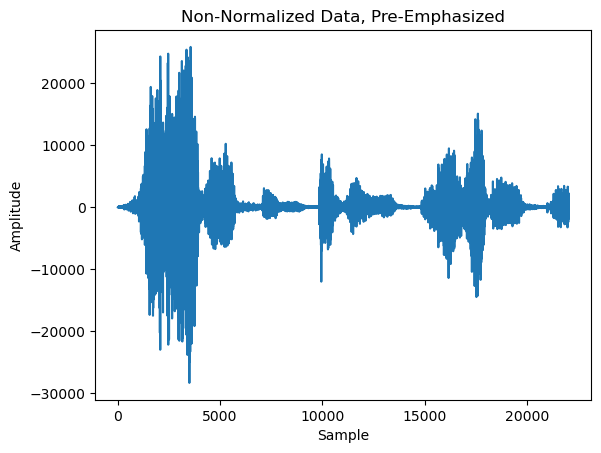

In [33]:
# 1. Pre-emphasis on the input signal

def pre_emphasis(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

pre_emphasis_signal = pre_emphasis(data)
plt.plot(pre_emphasis_signal)
plt.title('Non-Normalized Data, Pre-Emphasized')
plt.xlabel('Sample')
plt.ylabel('Amplitude')


Energy of the convolved signal: 109765800783220.84


Text(0, 0.5, 'Amplitude')

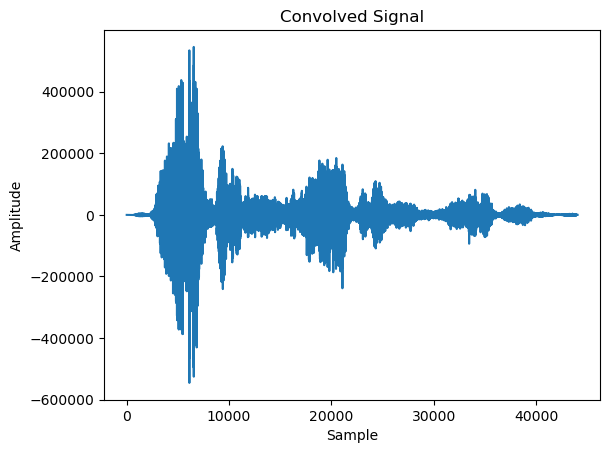

In [35]:
# Convolve pre-emphasis and Hamming windowed signal 
convolved_signal = np.convolve(windowed_signal, pre_emphasis_signal, mode='full') 
energy = np.sum(convolved_signal**2)
print("Energy of the convolved signal:", energy)
plt.plot(convolved_signal)
plt.title('Convolved Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

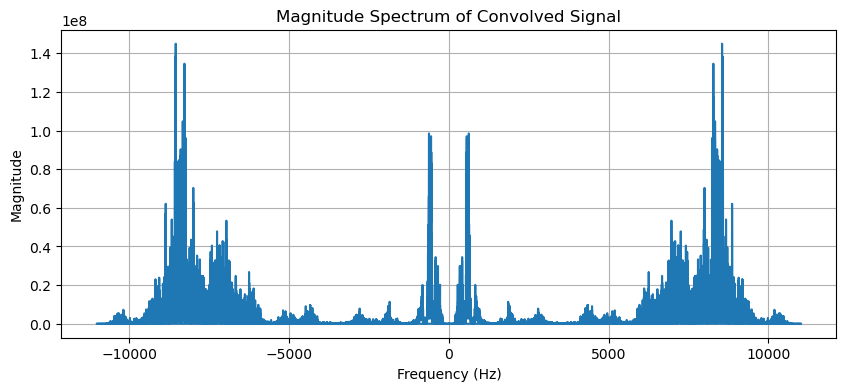

In [36]:
# Take the DFT 
dft_convolved_signal = np.fft.fft(convolved_signal)

# Compute the magnitude spectrum (absolute value of DFT)
magnitude_spectrum = np.abs(dft_convolved_signal)

# Compute the frequency bins
sample_rate = sample_rate  # Example sample rate, replace with your actual sample rate
N = len(convolved_signal)
frequency_bins = np.fft.fftfreq(N, d=1/sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(frequency_bins, magnitude_spectrum)
plt.title('Magnitude Spectrum of Convolved Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

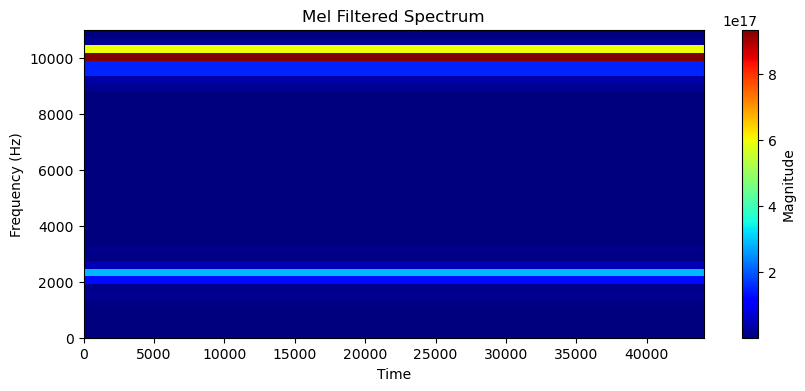

In [42]:
# square the output of DFT and apply Mel-Scale filtering 
import numpy as np
import matplotlib.pyplot as plt

def mel2hz(mel):
    """Convert Mel frequency to Hz."""
    return 700 * (np.exp(mel / 1127) - 1)

def hz2mel(hz):
    """Convert Hz frequency to Mel."""
    return 1127 * np.log(1 + hz / 700)

# Assuming dft_convolved_signal and frequency_bins are already computed
# dft_convolved_signal = np.fft.fft(convolved_signal)
# frequency_bins = np.fft.fftfreq(N, d=1/sample_rate)

# Compute squared magnitude spectrum
squared_magnitude_spectrum = np.square(np.abs(dft_convolved_signal))

# Define Mel scale parameters
num_filters = 40  # Number of Mel filters
min_freq = 0  # Minimum frequency in Hz
max_freq = sample_rate / 2  # Maximum frequency in Hz (Nyquist frequency)
mel_min = hz2mel(min_freq)
mel_max = hz2mel(max_freq)

# Create Mel filter bank
mel_filters = np.linspace(mel_min, mel_max, num_filters+2)
hz_filters = mel2hz(mel_filters)
filter_bank = np.zeros((num_filters, len(frequency_bins)))

# Populate filter bank
for i in range(1, num_filters+1):
    lower = int(np.floor(hz_filters[i - 1] / (sample_rate / len(frequency_bins))))
    center = int(np.round(hz_filters[i] / (sample_rate / len(frequency_bins))))
    upper = int(np.ceil(hz_filters[i + 1] / (sample_rate / len(frequency_bins))))
    for j in range(lower, upper):
        filter_bank[i - 1, j] = (j - lower) / (center - lower)
    for j in range(center, upper):
        filter_bank[i - 1, j] = (upper - j) / (upper - center)

# Apply Mel scale filtering
filtered_spectrum = np.dot(squared_magnitude_spectrum, filter_bank.T)

# Plot Mel filtered spectrum
plt.figure(figsize=(10, 4))
plt.imshow(np.reshape(filtered_spectrum.T, (-1, 1)), aspect='auto', origin='lower', cmap='jet', extent=[0, len(convolved_signal), min_freq, max_freq])
plt.colorbar(label='Magnitude')
plt.title('Mel Filtered Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()


c:\Users\ssshr\anaconda3\envs\my-hml\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


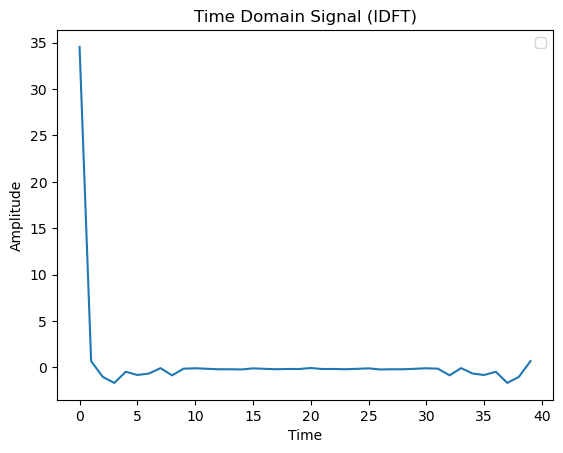

In [47]:
# log and IDFT of mel filtering 
log_filtered_spectrum = np.log(filtered_spectrum)

idft_log_filtered = np.fft.ifft(log_filtered_spectrum)

plt.plot(idft_log_filtered)
#plt.plot(np.imag(idft_log_filtered), label='Imaginary part')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time Domain Signal (IDFT)')
plt.legend()
plt.show()

### Measure Power Density